In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1. Starting by understanding and visualizing the data

In [ ]:

df = pd.read_csv('data_ncov2019.csv/prod_export_20250412_1744430420/PROCESSED/data_ncov2019.csv')  # Adjust filename/path
print(df.head())
print(df.info())


  EVENT_NAME              SOURCE    DATE_LOW   DATE_HIGH DATE_REPORT  \
0  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
1  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
2  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
3  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
4  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   

       DATE_TYPE SPATIAL_RESOLUTION AL0_CODE AL0_NAME AL1_CODE AL1_NAME  \
0  Symptom onset                AL0       CN    China      NaN      NaN   
1  Symptom onset                AL0       CN    China      NaN      NaN   
2  Symptom onset                AL0       CN    China      NaN      NaN   
3  Symptom onset                AL0       CN    China      NaN      NaN   
4  Symptom onset                AL0       CN    China      NaN      NaN   

  AL2_NAME AL3_NAME LOCALITY_NAME LOCATION_TYPE CONFIRM_STATUS OUTCOME  \
0      NaN      NaN           NaN      Exp

Global Cumulative Confirmed Cases (Country-level)

['EVENT_NAME', 'SOURCE', 'DATE_LOW', 'DATE_HIGH', 'DATE_REPORT', 'DATE_TYPE', 'SPATIAL_RESOLUTION', 'AL0_CODE', 'AL0_NAME', 'AL1_CODE', 'AL1_NAME', 'AL2_NAME', 'AL3_NAME', 'LOCALITY_NAME', 'LOCATION_TYPE', 'CONFIRM_STATUS', 'OUTCOME', 'CUMULATIVE_FLAG', 'VALUE']


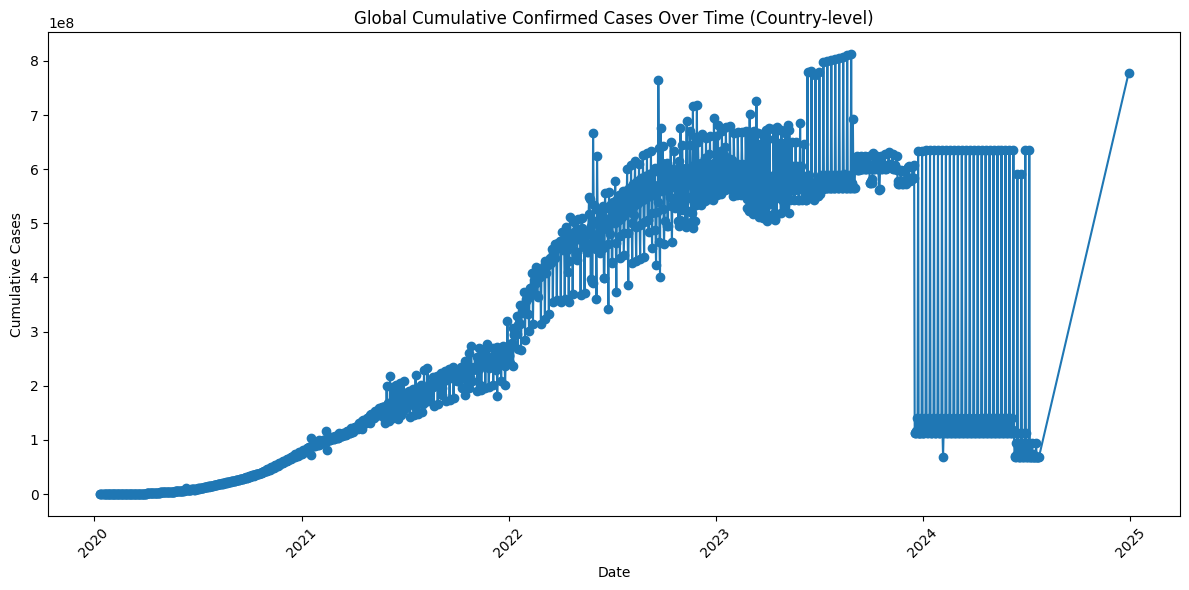

In [7]:
# Display all column names in the dataframe
print(df.columns.tolist())

# Filter for global cumulative confirmed cases at country level
global_mask = (
    (df['CUMULATIVE_FLAG'] == True) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &  # Use correct column name here
    (df['SPATIAL_RESOLUTION'] == 'AL0') &
    (df['OUTCOME'] == 'CASE')
)
global_df = df[global_mask].copy()
global_df['DATE'] = pd.to_datetime(global_df['DATE_REPORT'])  # Adjust the date field if needed

# Group by DATE_REPORT (summing over all countries)
global_daily = global_df.groupby('DATE')['VALUE'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(global_daily['DATE'], global_daily['VALUE'], marker='o')
plt.title('Global Cumulative Confirmed Cases Over Time (Country-level)')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



New York State: Cumulative Confirmed Cases

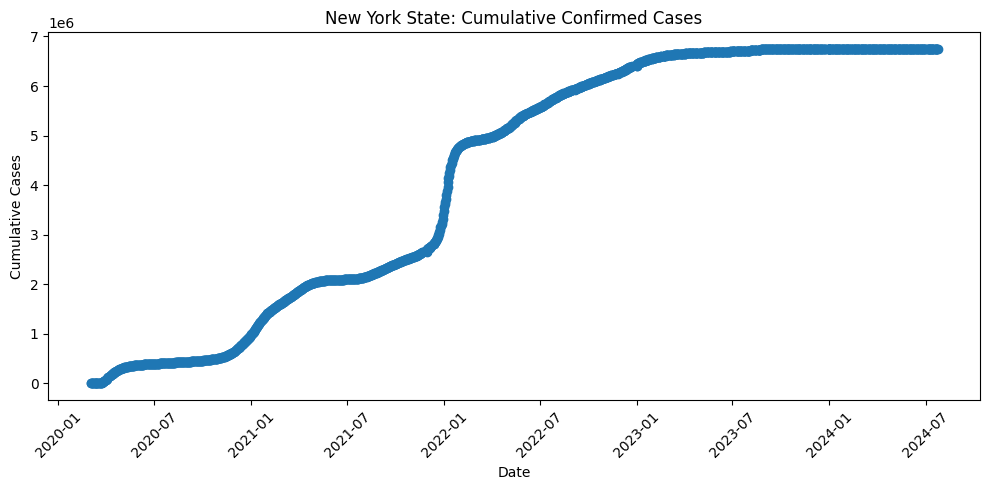

In [8]:
# Filter for New York State cumulative confirmed cases from the Multisource Fusion source
ny_mask = (
    (df['SOURCE'].str.contains('Multisource Fusion')) &
    (df['SPATIAL_RESOLUTION'] == 'AL1') &
    ((df['AL1_CODE'] == 'US-NY') | (df['AL1_NAME'].str.contains('New York'))) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &  # Use 'CONFIRM_STATUS'
    (df['OUTCOME'] == 'CASE') &
    (df['CUMULATIVE_FLAG'] == True)
)
ny_data = df[ny_mask].copy()
ny_data['DATE'] = pd.to_datetime(ny_data['DATE_REPORT'])
ny_data.sort_values('DATE', inplace=True)

plt.figure(figsize=(10,5))
plt.plot(ny_data['DATE'], ny_data['VALUE'], marker='o')
plt.title('New York State: Cumulative Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Daily New Cases for New York

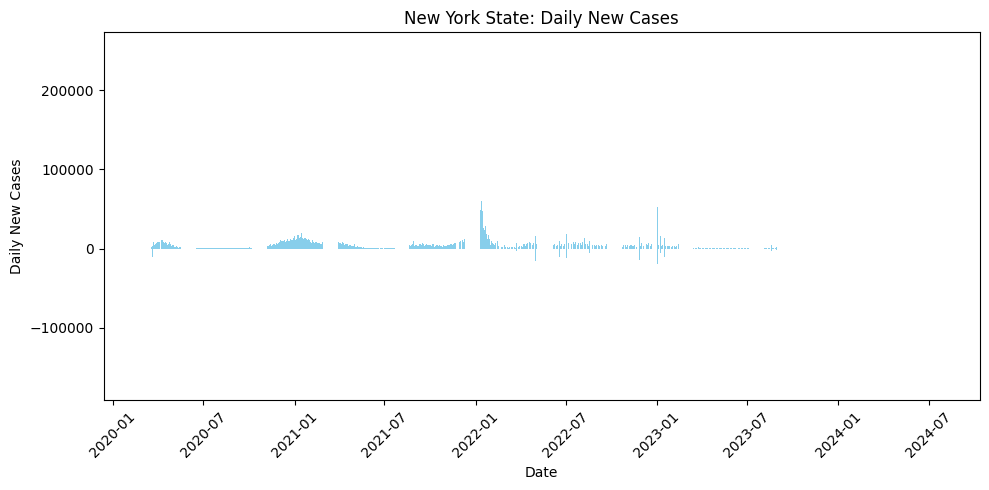

In [9]:
# Calculate daily new cases by taking the difference between consecutive cumulative counts
ny_data['Daily_New'] = ny_data['VALUE'].diff()

plt.figure(figsize=(10,5))
plt.bar(ny_data['DATE'], ny_data['Daily_New'], color='skyblue')
plt.title('New York State: Daily New Cases')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Comparing Multiple Countries

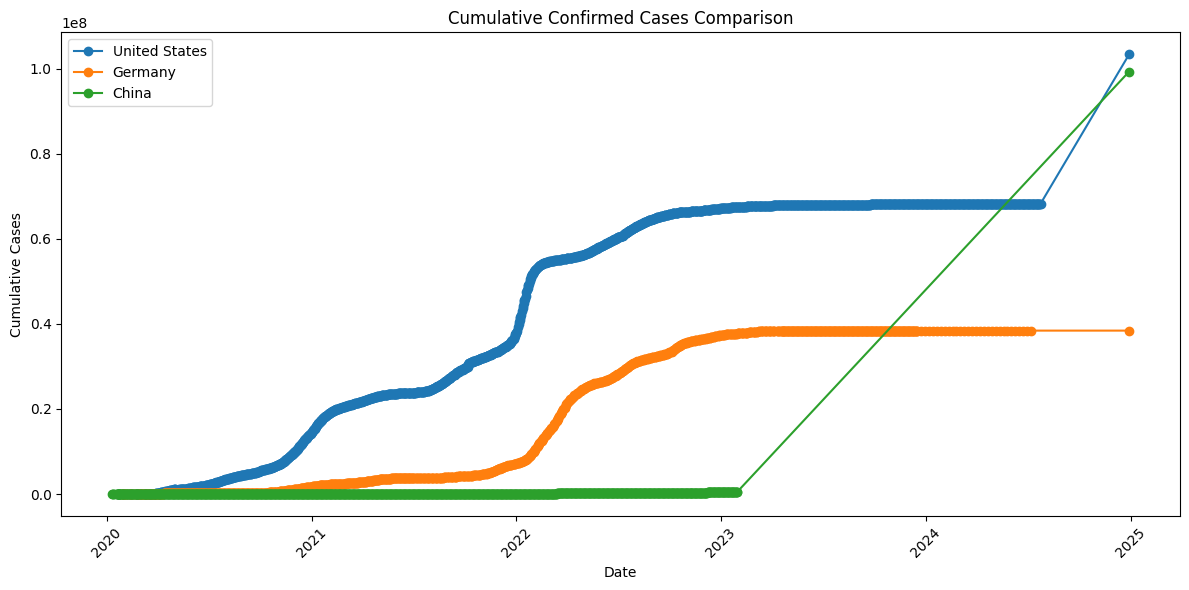

In [10]:
countries = ['United States', 'Germany', 'China']
country_data = {}

for country in countries:
    mask = (
        (df['CUMULATIVE_FLAG'] == True) &
        (df['CONFIRM_STATUS'] == 'CONFIRMED') &
        (df['SPATIAL_RESOLUTION'] == 'AL0') &
        (df['OUTCOME'] == 'CASE') &
        (df['AL0_NAME'] == country)
    )
    temp = df[mask].copy()
    temp['DATE'] = pd.to_datetime(temp['DATE_REPORT'])
    temp.sort_values('DATE', inplace=True)
    country_data[country] = temp

plt.figure(figsize=(12,6))
for country in countries:
    plt.plot(country_data[country]['DATE'], country_data[country]['VALUE'], marker='o', label=country)
plt.title('Cumulative Confirmed Cases Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Distribution of Daily New Cases

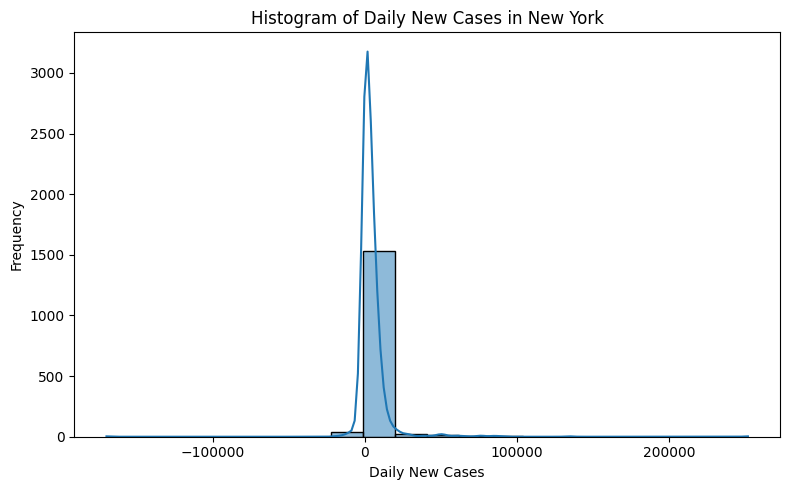

In [11]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(ny_data['Daily_New'].dropna(), bins=20, kde=True)
plt.title('Histogram of Daily New Cases in New York')
plt.xlabel('Daily New Cases')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Heatmap of Cumulative Cases Across Countries

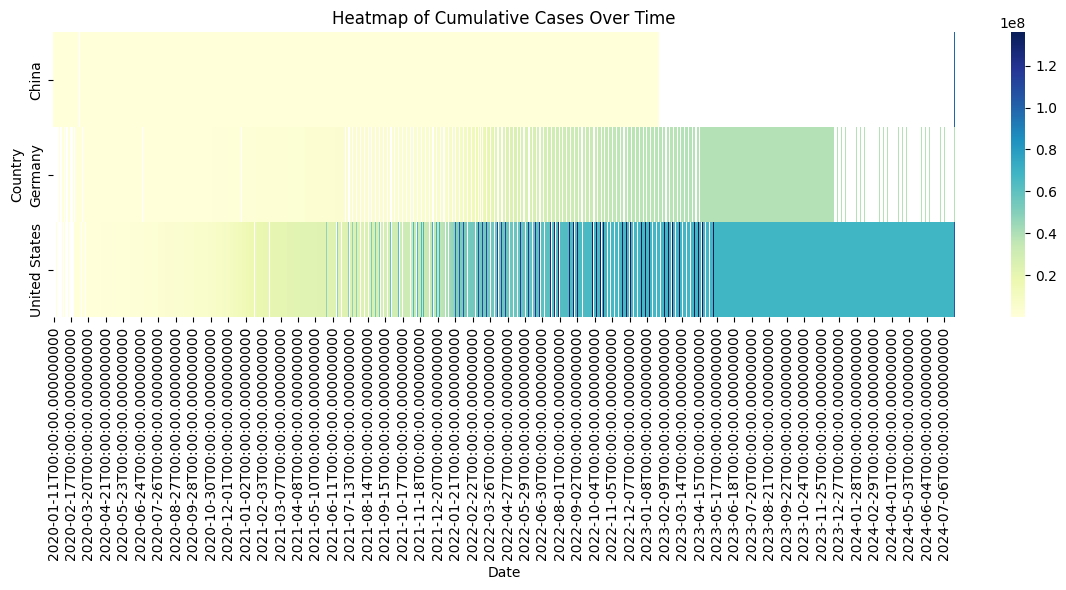

In [12]:
# Filter for a selected set of countries for the heatmap
heatmap_mask = (
    (df['CUMULATIVE_FLAG'] == True) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &
    (df['SPATIAL_RESOLUTION'] == 'AL0') &
    (df['OUTCOME'] == 'CASE') &
    (df['AL0_NAME'].isin(countries))
)
heat_df = df[heatmap_mask].copy()
heat_df['DATE'] = pd.to_datetime(heat_df['DATE_REPORT'])

# Pivot the data: rows = DATE, columns = Country, values = cumulative counts
pivot_df = heat_df.pivot_table(index='DATE', columns='AL0_NAME', values='VALUE', aggfunc='sum')

plt.figure(figsize=(12,6))
sns.heatmap(pivot_df.T, cmap='YlGnBu')
plt.title('Heatmap of Cumulative Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


Correlation Between Cases and Deaths

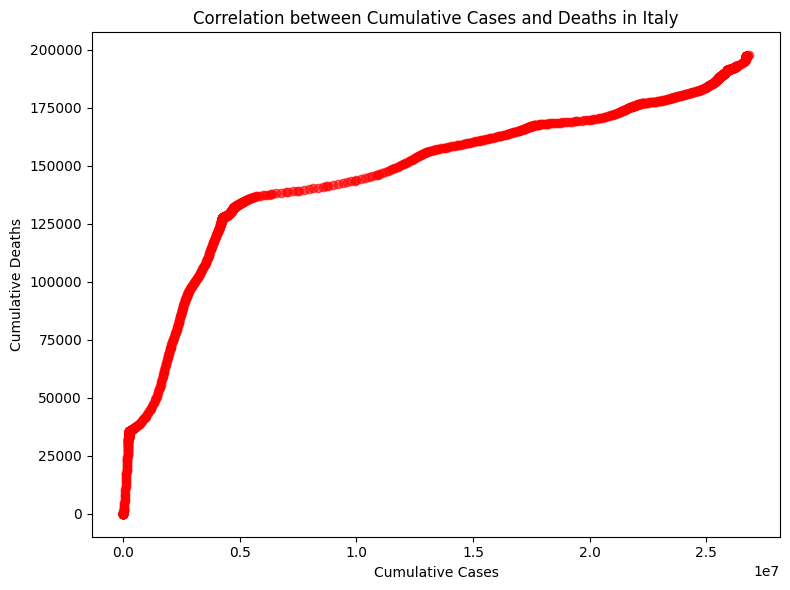

In [15]:
# Example for a selected country (e.g., Italy)

# Filter cumulative confirmed CASES
cases_mask = (
    (df['CUMULATIVE_FLAG'] == True) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &
    (df['SPATIAL_RESOLUTION'] == 'AL0') &
    (df['OUTCOME'] == 'CASE') &
    (df['AL0_NAME'] == 'Italy')
)
cases = df[cases_mask].copy()
cases['DATE'] = pd.to_datetime(cases['DATE_REPORT'])

# Filter cumulative confirmed DEATHS
deaths_mask = (
    (df['CUMULATIVE_FLAG'] == True) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &
    (df['SPATIAL_RESOLUTION'] == 'AL0') &
    (df['OUTCOME'] == 'DEATH') &
    (df['AL0_NAME'] == 'Italy')
)
deaths = df[deaths_mask].copy()
deaths['DATE'] = pd.to_datetime(deaths['DATE_REPORT'])

# Merge the two on DATE
merged = pd.merge(cases[['DATE', 'VALUE']], deaths[['DATE', 'VALUE']], on='DATE', suffixes=('_cases', '_deaths'))

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(merged['VALUE_cases'], merged['VALUE_deaths'], color='red', alpha=0.6)
plt.title('Correlation between Cumulative Cases and Deaths in Italy')
plt.xlabel('Cumulative Cases')
plt.ylabel('Cumulative Deaths')
plt.tight_layout()
plt.show()


Compute correlation for different lags, for example, lags of 0 to 14 days.

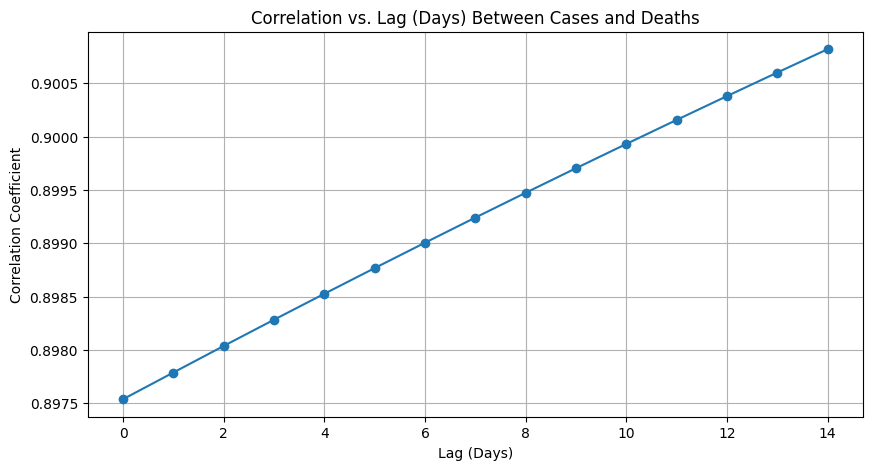

In [16]:
# Compute correlation for different lags, for example, lags of 0 to 14 days.
lags = range(0, 15)
correlations = []

for lag in lags:
    shifted = merged.copy()
    shifted['VALUE_deaths_shifted'] = shifted['VALUE_deaths'].shift(lag)
    corr = shifted[['VALUE_cases', 'VALUE_deaths_shifted']].corr().iloc[0, 1]
    correlations.append(corr)

plt.figure(figsize=(10,5))
plt.plot(lags, correlations, marker='o')
plt.title('Correlation vs. Lag (Days) Between Cases and Deaths')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()


Time-Series Decomposition
What to Do:

Objective: Decompose the daily new cases or cumulative cases into trend, seasonal, and residual components.

How: Use the seasonal_decompose function from the statsmodels library.

Why: This helps to understand underlying patterns, such as weekly seasonality or long-term trends.


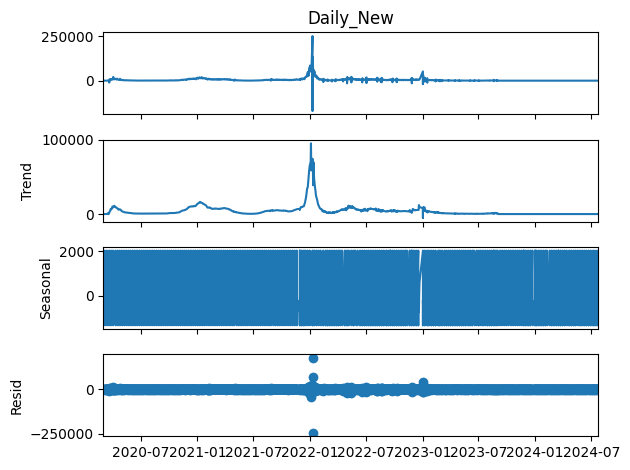

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use New York State's daily new cases as an example; ensure the time series is complete.
ny_data.set_index('DATE', inplace=True)
ny_series = ny_data['Daily_New'].fillna(0)  # Replace NaN with 0 if necessary

result = seasonal_decompose(ny_series, model='additive', period=7)  # Assuming weekly seasonality

result.plot()
plt.show()



 Temporal Correlation: Autocorrelation for Daily New Cases

<Figure size 1000x500 with 0 Axes>

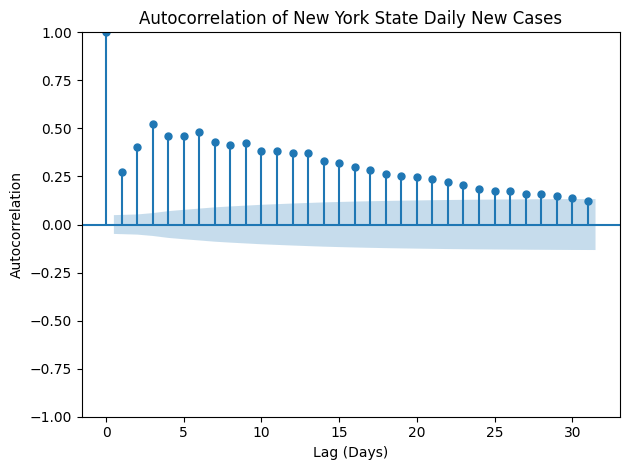

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assume you have already filtered New York State data (level AL1)
ny_mask = (
    (df['SOURCE'].str.contains('Multisource Fusion')) &
    (df['SPATIAL_RESOLUTION'] == 'AL1') &
    ((df['AL1_CODE'] == 'US-NY') | (df['AL1_NAME'].str.contains('New York'))) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &
    (df['OUTCOME'] == 'CASE') &
    (df['CUMULATIVE_FLAG'] == True)
)
ny_data = df[ny_mask].copy()
ny_data['DATE'] = pd.to_datetime(ny_data['DATE_REPORT'])
ny_data.sort_values('DATE', inplace=True)

# Calculate daily new cases from cumulative values
ny_data['Daily_New'] = ny_data['VALUE'].diff()

# Plot autocorrelation for daily new cases, up to 31 days lag
plt.figure(figsize=(10,5))
plot_acf(ny_data['Daily_New'].dropna(), lags=31)
plt.title('Autocorrelation of New York State Daily New Cases')
plt.xlabel('Lag (Days)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

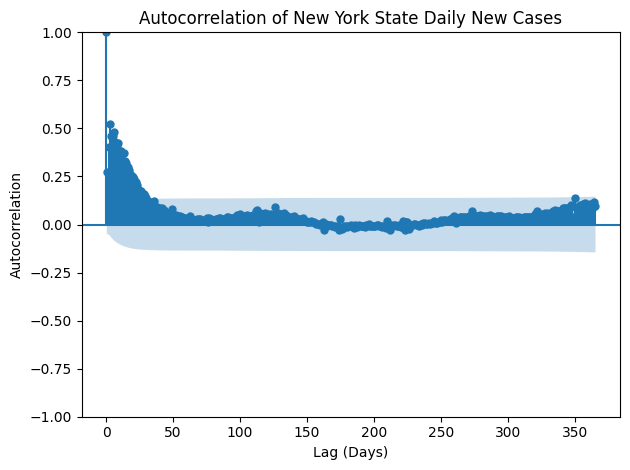

In [26]:
# Assume you have already filtered New York State data (level AL1)
ny_mask = (
    (df['SOURCE'].str.contains('Multisource Fusion')) &
    (df['SPATIAL_RESOLUTION'] == 'AL1') &
    ((df['AL1_CODE'] == 'US-NY') | (df['AL1_NAME'].str.contains('New York'))) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &
    (df['OUTCOME'] == 'CASE') &
    (df['CUMULATIVE_FLAG'] == True)
)
ny_data = df[ny_mask].copy()
ny_data['DATE'] = pd.to_datetime(ny_data['DATE_REPORT'])
ny_data.sort_values('DATE', inplace=True)

# Calculate daily new cases from cumulative values
ny_data['Daily_New'] = ny_data['VALUE'].diff()

# Plot autocorrelation for daily new cases, up to 31 days lag
plt.figure(figsize=(10,5))
plot_acf(ny_data['Daily_New'].dropna(), lags=365)
plt.title('Autocorrelation of New York State Daily New Cases')
plt.xlabel('Lag (Days)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()


 Spatial Correlation: Correlation Across Multiple Locations

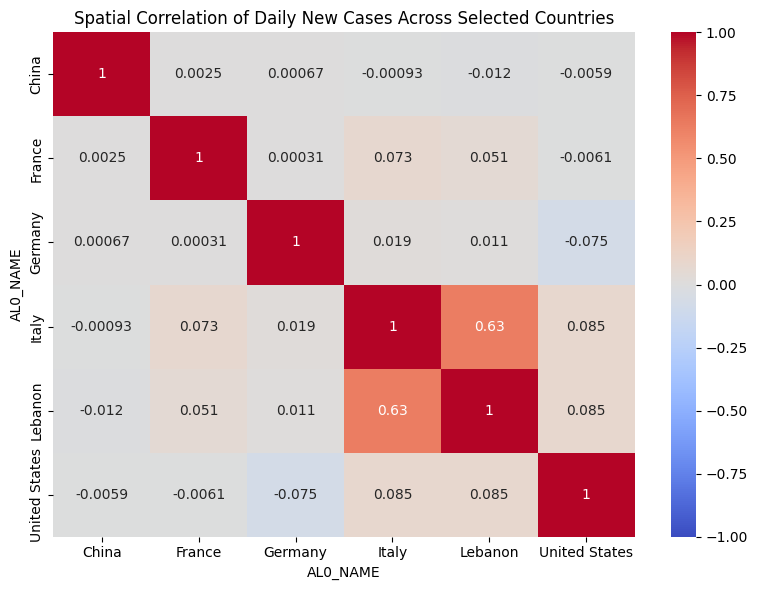

In [24]:
import seaborn as sns

# Select a set of countries (using AL0 level for country-level data)
selected_countries = ['United States', 'Italy', 'China', 'Germany', 'France', 'Lebanon']
mask = (
    (df['CUMULATIVE_FLAG'] == True) &
    (df['CONFIRM_STATUS'] == 'CONFIRMED') &
    (df['SPATIAL_RESOLUTION'] == 'AL0') &
    (df['OUTCOME'] == 'CASE') &
    (df['AL0_NAME'].isin(selected_countries))
)
selected_data = df[mask].copy()
selected_data['DATE'] = pd.to_datetime(selected_data['DATE_REPORT'])
selected_data.sort_values('DATE', inplace=True)

# Create a pivot table: rows=DATE, columns=Country, values=cumulative cases
pivot_data = selected_data.pivot_table(index='DATE', columns='AL0_NAME', values='VALUE', aggfunc='sum')

# Compute daily new cases from cumulative values; fill initial NaNs with 0
daily_new = pivot_data.diff().fillna(0)

# Compute correlation matrix across the countries' daily new cases
correlation_matrix = daily_new.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spatial Correlation of Daily New Cases Across Selected Countries')
plt.tight_layout()
plt.show()
